In [23]:
import numpy as np

from DORR_matrix import build_pauli_sum_A_strings, pauli_string_to_matrix, build_matrix_from_paulis

import matplotlib.pyplot as plt
import pennylane as qml

qml.QubitStateVector = qml.StatePrep

from device_var_lse_solver import DeviceVarLSESolver
from device import Device
from device import DeviceType
from qiskit_aer import AerSimulator

import numpy as np

from non_dynamical_ansatz import fixed_layered_ansatz
from tqdm import tqdm


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""

depth = 10

# As defined by [10]
def TRC_ADA(iteration_count : dict):
    trc = 0
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += d*z
    return trc

def TRC_ASA(iteration_count : dict):
    trc = 0
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += z*depth
    return trc

In [24]:
for KAPPA in [1.01,10]:
    pauli_strings, coeffs, b_state = build_pauli_sum_A_strings(qubits=3, J = 0.1, kappa=KAPPA)
    A_mat = build_matrix_from_paulis(pauli_strings, coeffs)

    cond = np.linalg.cond(A_mat)
    print(f"alpha = {KAPPA:.4e} -> condition number = {cond:.4e}")

b = np.ones(2**3)
b = b / np.linalg.norm(b)

alpha = 1.0100e+00 -> condition number = 1.0100e+00
alpha = 1.0000e+01 -> condition number = 1.0000e+01


In [28]:
qubits = 3
n = 2 ** qubits
kappa_list = [1.05,2,10,50]


device = Device(DeviceType.QISKIT_AER, qubits=qubits)

save = True
redo_calc = 10


lr = 0.05
threshold = 0.00001
steps = 2000
epochs = 10
abort = 200


results_list_dynamic = np.zeros([redo_calc, n])
results_list_static = np.zeros([redo_calc, n])
TRC_list_dynamic = np.zeros(redo_calc)
TRC_list_static = np.zeros(redo_calc)


depth = 10
param_shape = (qubits + depth*(qubits+qubits -2),)

for KAPPA in kappa_list:
    for i in range(redo_calc):
        print(f"Run nr. {i+1}/{redo_calc}")
        A, coeffs, b = build_pauli_sum_A_strings(qubits=qubits, J=0.1, kappa=KAPPA)

        ###################################
        #####    DYNAMIC NOISELESS    #####
        ###################################

        lse_dyn_dynamic = DeviceVarLSESolver(A, 
                    b, 
                    coeffs=coeffs,
                    method="hadamard", 
                    local=True, 
                    lr=lr, 
                    threshold=threshold,
                    steps=steps,
                    epochs=epochs, 
                    device=device, 
                    abort=abort,) 

        solution_local, param_local, it_count_local = lse_dyn_dynamic.solve()
        local_dense_trc = TRC_ASA(it_count_local)
        results_list_dynamic[i, :] = solution_local
        TRC_list_dynamic[i] = local_dense_trc


          
        ###################################
        #####    STATIC  NOISELESS    #####
        ###################################

        lse_stat_static = DeviceVarLSESolver(A,
                    b, 
                    coeffs=coeffs,
                    method='hadamard',
                    ansatz=fixed_layered_ansatz,
                    weights=param_shape,
                    local=True, 
                    lr=lr, 
                    steps=steps,
                    threshold=threshold, 
                    epochs=epochs,
                    device=device,
                    abort=abort,)
            


        solution_local, param_local, it_count_local = lse_stat_static.solve()
        results_list_static[i, :] = solution_local
        TRC_list_static[i] = TRC_ADA(it_count_local)



    if save == True:
        filename = f"data/condition_nr/result_local_condnr_{KAPPA}.npz"
        save_dict = {
            'A': A,
            'coeffs': coeffs,
            'b': b,
            'results_list_dynamic': results_list_dynamic,
            'TRC_list_dynamic': TRC_list_dynamic,
            'results_list_static': results_list_static,
            'TRC_list_static': TRC_list_static,
            'nr_runs': redo_calc,
            'KAPPA': KAPPA,
            'qubits': qubits,

        }
        np.savez(filename, **save_dict)
        print(f"Saved {filename}")


Run nr. 1/10
Epoch 1/10:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1/10:   6%|▌         | 117/2000 [00:18<04:55,  6.37it/s, best loss=1.25e-5, last improvement in step=116, loss=1.25e-5]
Loss of 0.0000085072 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   4%|▍         | 83/2000 [00:14<05:25,  5.89it/s, best loss=1.33e-5, last improvement in step=75, loss=1.26e-5]  
Loss of 0.0000018158 below stopping threshold.
Returning solution.
Run nr. 2/10
Epoch 1/10:   6%|▌         | 121/2000 [00:17<04:35,  6.83it/s, best loss=1.06e-5, last improvement in step=120, loss=1.06e-5]
Loss of 0.0000099449 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▍         | 95/2000 [00:15<05:16,  6.01it/s, best loss=1.11e-5, last improvement in step=90, loss=1.05e-5]  
Loss of 0.0000088229 below stopping threshold.
Returning solution.
Run nr. 3/10
Epoch 1/10:   6%|▌         | 111/2000 [00:16<04:38,  6.77it/s, best loss=1.08e-5, last improvement in step=110, loss=1.08e-5]
Loss of 0.0000083461 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   4%|▍         | 81/2000 [00:13<05:22,  5.96it/s, best loss=1.97e-5, last improvement in step=73, loss=2.76e-5]  
Loss of 0.0000093645 below stopping threshold.
Returning solution.
Run nr. 4/10
Epoch 1/10:   6%|▌         | 123/2000 [00:18<04:35,  6.82it/s, best loss=1.03e-5, last improvement in step=122, loss=1.03e-5]
Loss of 0.0000086010 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   3%|▎         | 68/2000 [00:11<05:21,  6.01it/s, best loss=1.05e-5, last improvement in step=60, loss=4.58e-5]  
Loss of 0.0000076794 below stopping threshold.
Returning solution.
Run nr. 5/10
Epoch 1/10:   5%|▍         | 99/2000 [00:14<04:42,  6.74it/s, best loss=1.07e-5, last improvement in step=97, loss=1.01e-5]  
Loss of 0.0000097824 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   4%|▍         | 87/2000 [00:14<05:19,  5.98it/s, best loss=1.5e-5, last improvement in step=80, loss=1.64e-5]   
Loss of 0.0000074923 below stopping threshold.
Returning solution.
Run nr. 6/10
Epoch 1/10:   6%|▌         | 119/2000 [00:17<04:36,  6.81it/s, best loss=1.08e-5, last improvement in step=118, loss=1.08e-5]
Loss of 0.0000087570 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   4%|▎         | 71/2000 [00:11<05:20,  6.02it/s, best loss=3.4e-5, last improvement in step=64, loss=4.44e-5]   
Loss of 0.0000075352 below stopping threshold.
Returning solution.
Run nr. 7/10
Epoch 1/10:   8%|▊         | 152/2000 [00:22<04:30,  6.82it/s, best loss=1.27e-5, last improvement in step=133, loss=1.42e-5]  
Loss of 0.0000096976 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   4%|▍         | 90/2000 [00:15<05:19,  5.98it/s, best loss=1.27e-5, last improvement in step=89, loss=1.27e-5]  
Loss of 0.0000089930 below stopping threshold.
Returning solution.
Run nr. 8/10
Epoch 1/10:   6%|▌         | 112/2000 [00:16<04:37,  6.80it/s, best loss=1.09e-5, last improvement in step=110, loss=1.01e-5]
Loss of 0.0000092139 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   4%|▍         | 83/2000 [00:13<05:17,  6.03it/s, best loss=1.97e-5, last improvement in step=76, loss=4.13e-5]  
Loss of 0.0000099275 below stopping threshold.
Returning solution.
Run nr. 9/10
Epoch 1/10:   6%|▌         | 123/2000 [00:18<04:35,  6.81it/s, best loss=1.02e-5, last improvement in step=122, loss=1.02e-5]
Loss of 0.0000076912 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   4%|▍         | 90/2000 [00:14<05:16,  6.03it/s, best loss=1.08e-5, last improvement in step=76, loss=1.91e-5]  
Loss of 0.0000089357 below stopping threshold.
Returning solution.
Run nr. 10/10
Epoch 1/10:   6%|▌         | 114/2000 [00:16<04:40,  6.74it/s, best loss=1.4e-5, last improvement in step=113, loss=1.4e-5]  
Loss of 0.0000097382 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▍         | 91/2000 [00:15<05:23,  5.90it/s, best loss=1.06e-5, last improvement in step=90, loss=1.06e-5]  
Loss of 0.0000093956 below stopping threshold.
Returning solution.
Saved data/condition_nr/result_local_condnr_1.05.npz
Run nr. 1/10
Epoch 1/10:  18%|█▊        | 353/2000 [00:53<04:07,  6.65it/s, best loss=9.26e-5, last improvement in step=153, loss=9.24e-5]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  56%|█████▌    | 1118/2000 [02:49<02:13,  6.60it/s, best loss=1.04e-5, last improvement in step=1109, loss=1e-5]   
Loss of 0.0000099955 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▍        | 298/2000 [00:51<04:53,  5.81it/s, best loss=4.67e-5, last improvement in step=98, loss=4.62e-5] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 2/10
Epoch 1/10:  17%|█▋        | 334/2000 [00:49<04:05,  6.78it/s, best loss=9.29e-5, last improvement in step=134, loss=9.24e-5]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  43%|████▎     | 851/2000 [02:09<02:55,  6.55it/s, best loss=4.69e-5, last improvement in step=651, loss=4.62e-5]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  19%|█▉        | 383/2000 [00:58<04:07,  6.54it/s, best loss=1.03e-5, last improvement in step=362, loss=1e-5]   
Loss of 0.0000099958 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  14%|█▍        | 280/2000 [00:46<04:47,  5.99it/s, best loss=4.67e-5, last improvement in step=80, loss=4.62e-5] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 3/10
Epoch 1/10:  17%|█▋        | 335/2000 [00:49<04:07,  6.71it/s, best loss=9.33e-5, last improvement in step=135, loss=9.24e-5]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  54%|█████▍    | 1080/2000 [02:42<02:18,  6.63it/s, best loss=1.06e-5, last improvement in step=1064, loss=1e-5]   
Loss of 0.0000099668 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  14%|█▍        | 290/2000 [00:48<04:47,  5.94it/s, best loss=4.68e-5, last improvement in step=90, loss=4.62e-5] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 4/10
Epoch 1/10:  18%|█▊        | 368/2000 [00:55<04:05,  6.65it/s, best loss=9.27e-5, last improvement in step=168, loss=9.24e-5]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  47%|████▋     | 944/2000 [02:22<02:39,  6.61it/s, best loss=1.06e-5, last improvement in step=926, loss=1e-5]     
Loss of 0.0000099961 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 315/2000 [00:52<04:40,  6.02it/s, best loss=4.67e-5, last improvement in step=115, loss=4.62e-5]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 5/10
Epoch 1/10:  15%|█▍        | 297/2000 [00:43<04:10,  6.80it/s, best loss=9.25e-5, last improvement in step=97, loss=9.24e-5] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  48%|████▊     | 962/2000 [02:27<02:38,  6.53it/s, best loss=1.09e-5, last improvement in step=943, loss=1e-5]     
Loss of 0.0000099771 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 313/2000 [00:52<04:44,  5.93it/s, best loss=4.62e-5, last improvement in step=113, loss=4.62e-5]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 6/10
Epoch 1/10:  17%|█▋        | 338/2000 [00:52<04:17,  6.46it/s, best loss=9.33e-5, last improvement in step=138, loss=9.24e-5]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  60%|██████    | 1204/2000 [03:00<01:59,  6.68it/s, best loss=4.72e-5, last improvement in step=1004, loss=4.63e-5]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10: 100%|██████████| 2000/2000 [05:30<00:00,  6.05it/s, best loss=1.63e-5, last improvement in step=1954, loss=1.58e-5]
Increasing circuit depth.
Epoch 4/10:  13%|█▎        | 257/2000 [00:44<05:03,  5.75it/s, best loss=1e-5, last improvement in step=256, loss=1e-5]      
Loss of 0.0000099752 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▌        | 308/2000 [00:57<05:14,  5.38it/s, best loss=4.63e-5, last improvement in step=108, loss=4.62e-5]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 7/10
Epoch 1/10:  17%|█▋        | 338/2000 [00:56<04:36,  6.02it/s, best loss=9.27e-5, last improvement in step=138, loss=9.24e-5]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  40%|███▉      | 795/2000 [02:09<03:15,  6.16it/s, best loss=1.08e-5, last improvement in step=782, loss=1e-5]    
Loss of 0.0000099528 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 315/2000 [00:57<05:06,  5.49it/s, best loss=4.65e-5, last improvement in step=115, loss=4.62e-5]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 8/10
Epoch 1/10:  18%|█▊        | 370/2000 [01:00<04:24,  6.17it/s, best loss=9.27e-5, last improvement in step=170, loss=9.24e-5]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  18%|█▊        | 354/2000 [00:57<04:26,  6.17it/s, best loss=9.17e-5, last improvement in step=154, loss=9.09e-5]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  52%|█████▏    | 1037/2000 [02:53<02:40,  5.99it/s, best loss=1e-5, last improvement in step=1036, loss=1e-5]      
Loss of 0.0000099853 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  17%|█▋        | 333/2000 [01:01<05:07,  5.42it/s, best loss=4.62e-5, last improvement in step=133, loss=4.62e-5]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 9/10
Epoch 1/10:  18%|█▊        | 352/2000 [00:56<04:24,  6.22it/s, best loss=9.24e-5, last improvement in step=152, loss=9.24e-5]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  59%|█████▉    | 1178/2000 [03:16<02:17,  5.98it/s, best loss=1.07e-5, last improvement in step=1158, loss=1e-5]   
Loss of 0.0000099984 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▍        | 299/2000 [00:56<05:23,  5.26it/s, best loss=4.68e-5, last improvement in step=99, loss=4.62e-5] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 10/10
Epoch 1/10:  16%|█▌        | 317/2000 [00:53<04:42,  5.96it/s, best loss=9.3e-5, last improvement in step=117, loss=9.24e-5]   
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  29%|██▊       | 571/2000 [01:42<04:16,  5.57it/s, best loss=1.05e-5, last improvement in step=557, loss=1e-5]     
Loss of 0.0000099936 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 322/2000 [01:02<05:27,  5.13it/s, best loss=4.63e-5, last improvement in step=122, loss=4.62e-5]
Loss has not improved in last 200 steps.
Returning best solution.
Saved data/condition_nr/result_local_condnr_2.npz
Run nr. 1/10
Epoch 1/10:  17%|█▋        | 343/2000 [00:54<04:23,  6.29it/s, best loss=0.0003, last improvement in step=143, loss=0.000299]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  50%|████▉     | 994/2000 [02:43<02:45,  6.08it/s, best loss=0.00992, last improvement in step=794, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   8%|▊         | 160/2000 [00:28<05:32,  5.53it/s, best loss=1.07e-5, last improvement in step=158, loss=1.02e-5]
Loss of 0.0000098039 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  14%|█▍        | 282/2000 [00:53<05:28,  5.23it/s, best loss=0.000151, last improvement in step=82, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 2/10
Epoch 1/10:  15%|█▍        | 296/2000 [00:50<04:47,  5.92it/s, best loss=0.0003, last improvement in step=96, loss=0.000299] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  61%|██████    | 1214/2000 [03:27<02:14,  5.86it/s, best loss=0.00992, last improvement in step=1014, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   9%|▉         | 183/2000 [00:31<05:13,  5.80it/s, best loss=1.02e-5, last improvement in step=181, loss=1e-5]   
Loss of 0.0000098859 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  14%|█▍        | 289/2000 [00:54<05:21,  5.32it/s, best loss=0.000151, last improvement in step=89, loss=0.000165]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 3/10
Epoch 1/10:  16%|█▌        | 324/2000 [00:54<04:39,  5.99it/s, best loss=0.0003, last improvement in step=124, loss=0.000299]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  33%|███▎      | 651/2000 [02:04<04:17,  5.25it/s, best loss=0.00992, last improvement in step=451, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  83%|████████▎ | 1664/2000 [04:28<00:54,  6.19it/s, best loss=1.04e-5, last improvement in step=1614, loss=1e-5]   
Loss of 0.0000099983 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▌        | 307/2000 [01:08<06:16,  4.50it/s, best loss=0.00015, last improvement in step=107, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 4/10
Epoch 1/10:  15%|█▌        | 306/2000 [01:13<06:47,  4.16it/s, best loss=0.0003, last improvement in step=106, loss=0.000299]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  58%|█████▊    | 1164/2000 [03:24<02:26,  5.70it/s, best loss=0.00992, last improvement in step=964, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  28%|██▊       | 562/2000 [01:34<04:00,  5.98it/s, best loss=1.1e-5, last improvement in step=548, loss=1e-5]      
Loss of 0.0000099354 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▌        | 306/2000 [00:54<05:02,  5.60it/s, best loss=0.000151, last improvement in step=106, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 5/10
Epoch 1/10:  17%|█▋        | 335/2000 [00:50<04:12,  6.59it/s, best loss=0.0003, last improvement in step=135, loss=0.000299]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  16%|█▌        | 324/2000 [00:52<04:32,  6.15it/s, best loss=0.0105, last improvement in step=124, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  52%|█████▏    | 1046/2000 [02:39<02:25,  6.56it/s, best loss=1.07e-5, last improvement in step=1019, loss=1e-5]   
Loss of 0.0000099965 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▌        | 302/2000 [00:49<04:40,  6.06it/s, best loss=0.00015, last improvement in step=102, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 6/10
Epoch 1/10:  15%|█▌        | 308/2000 [00:48<04:27,  6.33it/s, best loss=0.0003, last improvement in step=108, loss=0.000299]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  26%|██▌       | 516/2000 [01:34<04:32,  5.45it/s, best loss=0.00992, last improvement in step=316, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  17%|█▋        | 342/2000 [00:53<04:17,  6.45it/s, best loss=1.06e-5, last improvement in step=339, loss=1.02e-5]  
Loss of 0.0000099832 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 310/2000 [00:52<04:44,  5.93it/s, best loss=0.00015, last improvement in step=110, loss=0.00015]  
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 7/10
Epoch 1/10:  17%|█▋        | 345/2000 [00:51<04:08,  6.66it/s, best loss=0.0003, last improvement in step=145, loss=0.000299]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  16%|█▌        | 318/2000 [00:50<04:27,  6.28it/s, best loss=0.0105, last improvement in step=118, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  14%|█▍        | 282/2000 [00:46<04:45,  6.03it/s, best loss=1.06e-5, last improvement in step=279, loss=1.02e-5]  
Loss of 0.0000099597 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▍        | 291/2000 [00:50<04:53,  5.82it/s, best loss=0.000151, last improvement in step=91, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 8/10
Epoch 1/10:  18%|█▊        | 352/2000 [00:52<04:05,  6.70it/s, best loss=0.0003, last improvement in step=152, loss=0.000299]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  20%|██        | 410/2000 [01:02<04:02,  6.56it/s, best loss=0.00992, last improvement in step=210, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  84%|████████▍ | 1682/2000 [04:27<00:50,  6.28it/s, best loss=1.02e-5, last improvement in step=1646, loss=1e-5]   
Loss of 0.0000099956 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▌        | 301/2000 [00:50<04:45,  5.95it/s, best loss=0.000151, last improvement in step=101, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 9/10
Epoch 1/10:  19%|█▊        | 373/2000 [00:55<04:03,  6.69it/s, best loss=0.000299, last improvement in step=173, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  29%|██▉       | 579/2000 [01:29<03:40,  6.45it/s, best loss=0.0102, last improvement in step=379, loss=0.0102]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  30%|███       | 605/2000 [01:34<03:38,  6.38it/s, best loss=1.05e-5, last improvement in step=601, loss=1.01e-5]  
Loss of 0.0000099978 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 312/2000 [00:52<04:46,  5.89it/s, best loss=0.00015, last improvement in step=112, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 10/10
Epoch 1/10:  17%|█▋        | 340/2000 [00:50<04:08,  6.67it/s, best loss=0.0003, last improvement in step=140, loss=0.000299]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  22%|██▏       | 444/2000 [01:07<03:58,  6.54it/s, best loss=0.0102, last improvement in step=244, loss=0.0102]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  54%|█████▍    | 1082/2000 [02:50<02:24,  6.36it/s, best loss=1.1e-5, last improvement in step=1076, loss=1.01e-5] 
Loss of 0.0000099341 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 321/2000 [00:54<04:45,  5.88it/s, best loss=0.00015, last improvement in step=121, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Saved data/condition_nr/result_local_condnr_10.npz
Run nr. 1/10
Epoch 1/10:  18%|█▊        | 367/2000 [00:55<04:06,  6.63it/s, best loss=0.000356, last improvement in step=167, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  43%|████▎     | 865/2000 [02:12<02:53,  6.53it/s, best loss=0.000683, last improvement in step=665, loss=0.000683]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  10%|█         | 208/2000 [00:32<04:43,  6.32it/s, best loss=1.03e-5, last improvement in step=206, loss=1.01e-5]
Loss of 0.0000099987 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  14%|█▍        | 286/2000 [00:48<04:50,  5.90it/s, best loss=0.000179, last improvement in step=86, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 2/10
Epoch 1/10:  17%|█▋        | 344/2000 [00:51<04:09,  6.63it/s, best loss=0.000355, last improvement in step=144, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  39%|███▉      | 780/2000 [01:59<03:06,  6.52it/s, best loss=0.000683, last improvement in step=580, loss=0.000683]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  36%|███▌      | 723/2000 [01:52<03:19,  6.41it/s, best loss=1.01e-5, last improvement in step=721, loss=1e-5]     
Loss of 0.0000099915 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  14%|█▍        | 284/2000 [00:47<04:49,  5.92it/s, best loss=0.000179, last improvement in step=84, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 3/10
Epoch 1/10:  19%|█▉        | 384/2000 [00:56<03:59,  6.75it/s, best loss=0.000355, last improvement in step=184, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  39%|███▉      | 787/2000 [01:59<03:03,  6.60it/s, best loss=0.000403, last improvement in step=587, loss=0.000402]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  17%|█▋        | 345/2000 [00:53<04:17,  6.43it/s, best loss=1.07e-5, last improvement in step=269, loss=1e-5]   
Loss of 0.0000099974 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▌        | 309/2000 [00:52<04:48,  5.87it/s, best loss=0.000178, last improvement in step=109, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 4/10
Epoch 1/10:  18%|█▊        | 356/2000 [00:53<04:06,  6.68it/s, best loss=0.000355, last improvement in step=156, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  30%|███       | 610/2000 [01:32<03:31,  6.57it/s, best loss=0.000401, last improvement in step=410, loss=0.0004]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  29%|██▉       | 575/2000 [01:31<03:46,  6.30it/s, best loss=1.01e-5, last improvement in step=564, loss=1e-5]     
Loss of 0.0000099964 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  14%|█▍        | 290/2000 [00:48<04:46,  5.96it/s, best loss=0.000179, last improvement in step=90, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 5/10
Epoch 1/10:  21%|██        | 420/2000 [01:02<03:55,  6.70it/s, best loss=0.000355, last improvement in step=220, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  16%|█▋        | 326/2000 [00:51<04:22,  6.37it/s, best loss=0.000965, last improvement in step=126, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  31%|███       | 613/2000 [01:35<03:36,  6.40it/s, best loss=1.04e-5, last improvement in step=604, loss=1e-5]     
Loss of 0.0000099750 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▌        | 309/2000 [00:51<04:41,  6.01it/s, best loss=0.000178, last improvement in step=109, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 6/10
Epoch 1/10:  16%|█▋        | 330/2000 [00:48<04:05,  6.79it/s, best loss=0.000355, last improvement in step=130, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  17%|█▋        | 338/2000 [00:50<04:10,  6.64it/s, best loss=0.000965, last improvement in step=138, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  36%|███▋      | 727/2000 [01:51<03:14,  6.53it/s, best loss=1.02e-5, last improvement in step=721, loss=1e-5]     
Loss of 0.0000099731 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▍        | 295/2000 [00:48<04:41,  6.05it/s, best loss=0.000179, last improvement in step=95, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 7/10
Epoch 1/10:  16%|█▌        | 317/2000 [00:46<04:06,  6.83it/s, best loss=0.000356, last improvement in step=117, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  16%|█▌        | 319/2000 [00:47<04:11,  6.69it/s, best loss=0.000965, last improvement in step=119, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  19%|█▉        | 387/2000 [00:58<04:04,  6.61it/s, best loss=1.07e-5, last improvement in step=381, loss=1.01e-5]  
Loss of 0.0000099823 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 319/2000 [00:52<04:36,  6.08it/s, best loss=0.000178, last improvement in step=119, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 8/10
Epoch 1/10:  17%|█▋        | 348/2000 [00:50<04:00,  6.86it/s, best loss=0.000355, last improvement in step=148, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  17%|█▋        | 336/2000 [00:49<04:07,  6.72it/s, best loss=0.000965, last improvement in step=136, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  27%|██▋       | 549/2000 [01:23<03:40,  6.59it/s, best loss=1.01e-5, last improvement in step=547, loss=1e-5]     
Loss of 0.0000099110 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 321/2000 [00:53<04:38,  6.03it/s, best loss=0.000179, last improvement in step=121, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 9/10
Epoch 1/10:  17%|█▋        | 331/2000 [00:48<04:02,  6.89it/s, best loss=0.000355, last improvement in step=131, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  19%|█▊        | 373/2000 [00:55<04:00,  6.75it/s, best loss=0.000401, last improvement in step=173, loss=0.000401]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  29%|██▉       | 584/2000 [01:28<03:33,  6.63it/s, best loss=1.06e-5, last improvement in step=576, loss=1e-5]     
Loss of 0.0000099282 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  15%|█▍        | 299/2000 [00:49<04:39,  6.10it/s, best loss=0.000179, last improvement in step=99, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 10/10
Epoch 1/10:  19%|█▊        | 374/2000 [00:54<03:56,  6.89it/s, best loss=0.000355, last improvement in step=174, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  21%|██        | 424/2000 [01:02<03:53,  6.75it/s, best loss=0.000402, last improvement in step=224, loss=0.000401]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  17%|█▋        | 332/2000 [00:49<04:11,  6.64it/s, best loss=1.05e-5, last improvement in step=326, loss=1.01e-5]  
Loss of 0.0000099765 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:  16%|█▌        | 317/2000 [00:52<04:36,  6.09it/s, best loss=0.000178, last improvement in step=117, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Saved data/condition_nr/result_local_condnr_50.npz


In [ ]:
kappa_list = [1.05,2,10,50]

In [32]:
mean_results_dynamic = np.zeros([len(kappa_list), n])
std_results_dynamic = np.zeros([len(kappa_list), n])
mean_trc_dynamic = np.zeros(len(kappa_list))
std_trc_dynamic = np.zeros(len(kappa_list))

mean_results_static = np.zeros([len(kappa_list), n])
std_results_static = np.zeros([len(kappa_list), n])
mean_trc_static = np.zeros(len(kappa_list))
std_trc_static = np.zeros(len(kappa_list))


classical_solution = np.zeros([len(kappa_list), n])

for i, KAPPA in enumerate(kappa_list):

    filename = f"data/condition_nr/result_local_condnr_{KAPPA}.npz"
    data = np.load(filename)
    
    A = data['A']
    coeffs = data['coeffs']
    b = data['b']
    results_list_dynamic = data['results_list_dynamic']
    TRC_list_dynamic = data['TRC_list_dynamic']
    results_list_static = data['results_list_static']
    TRC_list_static = data['TRC_list_static']
    nr_runs = data['nr_runs']
    KAPPA = data['KAPPA']
    qubits = data['qubits'] 


    mean_results_dynamic[i, :] = np.mean(results_list_dynamic, axis=0)
    std_results_dynamic[i, :] = np.std(results_list_dynamic, axis=0)/ np.sqrt(nr_runs)
    mean_trc_dynamic[i] = np.mean(TRC_list_dynamic)
    std_trc_dynamic[i] = np.std(TRC_list_dynamic)/ np.sqrt(nr_runs)

    mean_results_static[i, :] = np.mean(results_list_static, axis=0)
    std_results_static[i, :] = np.std(results_list_static, axis=0)/ np.sqrt(nr_runs)
    mean_trc_static[i] = np.mean(TRC_list_static)
    std_trc_static[i] = np.std(TRC_list_static)/ np.sqrt(nr_runs)

    # compute normalized classical solution for comparison, therefore first re-compose system matrix A
    pauli_strings, coeffs, b = build_pauli_sum_A_strings(qubits=int(qubits), kappa=KAPPA)
    A_mat = build_matrix_from_paulis(pauli_strings, coeffs)
    x_classical = np.linalg.solve(A_mat, b)
    normalized_classical_solution = np.square(np.abs(x_classical / np.linalg.norm(x_classical)))

    classical_solution[i, :] = normalized_classical_solution



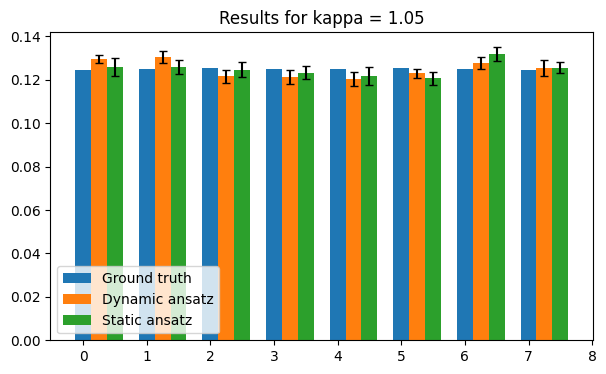

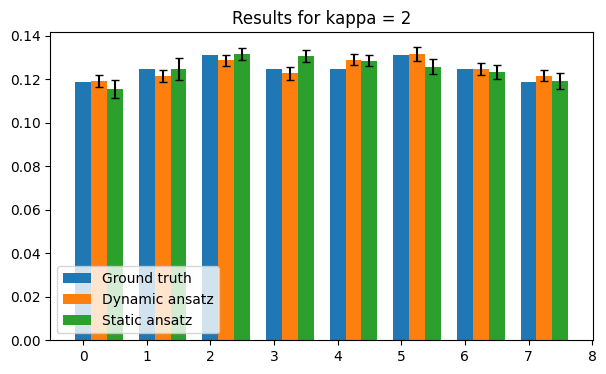

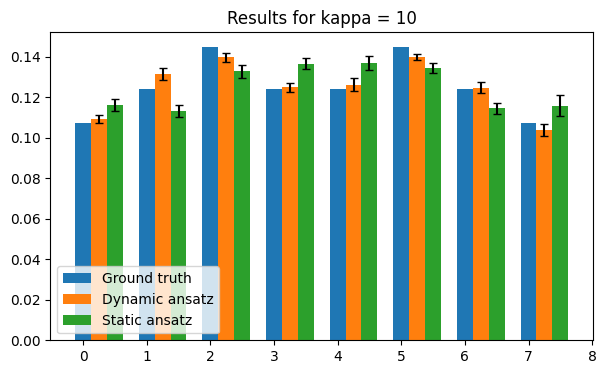

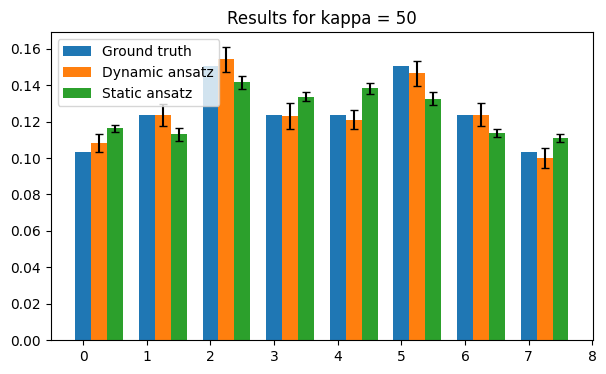

In [34]:
for i, KAPPA in enumerate(kappa_list):

    plt.figure(figsize=(7, 4))
    plt.title(f"Results for kappa = {KAPPA}")

    x = np.arange(len(classical_solution[i, :])) 
    width = 0.25 
    multiplier = 0
    
    plt.bar(x, classical_solution[i, :], width = width, label='Ground truth')
    plt.bar(x + width,  mean_results_dynamic[i, :], yerr=std_results_dynamic[i, :], width=width, capsize=3, label='Dynamic ansatz')
    plt.bar(x + 2*width, mean_results_static[i, :], yerr=std_results_static[i, :], width=width, capsize=3, label='Static ansatz')
    plt.legend()
    plt.show()